<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [ ]:
# Uninstall all known langchain-related packages, and ragatouille for a clean slate.
!pip uninstall -y langchain langchain-core langchain-community langchain-openai langchain-text-splitters langsmith
!pip uninstall -y ragatouille

# Install base dependencies without specifying langchain to avoid conflicts.
!pip install -q gdown torch transformers accelerate bitsandbytes sentence-transformers faiss-cpu openpyxl datasets umap-learn

# Reinstall ragatouille, allowing it to pull in its own compatible langchain dependencies.
!pip install ragatouille==0.0.9post2

# Explicitly install langchain-community to ensure it's present and compatible
!pip install langchain-community

!pip install langchain_groq

Found existing installation: langchain 1.1.0
Uninstalling langchain-1.1.0:
  Successfully uninstalled langchain-1.1.0
Found existing installation: langchain-core 1.1.0
Uninstalling langchain-core-1.1.0:
  Successfully uninstalled langchain-core-1.1.0
Found existing installation: langchain-text-splitters 1.0.0
Uninstalling langchain-text-splitters-1.0.0:
  Successfully uninstalled langchain-text-splitters-1.0.0
Found existing installation: langsmith 0.4.49
Uninstalling langsmith-0.4.49:
  Successfully uninstalled langsmith-0.4.49
Found existing installation: RAGatouille 0.0.9.post2
Uninstalling RAGatouille-0.0.9.post2:
  Successfully uninstalled RAGatouille-0.0.9.post2
  Using cached ragatouille-0.0.9.post2-py3-none-any.whl.metadata (28 kB)
  Using cached langchain_core-1.1.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached langchain-1.1.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached langsmith-0.4.49-py3-none-any.whl.metadata (14 kB)
Using cached ragatouille-0.0.9.post2-py3-none-a

In [2]:
pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
#!pip uninstall -y langchain langchain-core
#!pip install langchain==0.0.350
# The above lines are commented out as they caused a dependency conflict.
# Removing the explicit langchain==0.0.350 constraint allows ragatouille to install compatible langchain dependencies.

In [79]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain_core.documents import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [2]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv',index_col = 0)

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=60880eab-c5c8-46ca-8f88-0bfa2b30f226
To: /content/file.csv
100%|██████████| 672M/672M [00:06<00:00, 104MB/s]


In [3]:
data.isna().sum()/len(data) * 100

,0
Name,0.000000
WikiData,17.466175
City,0.000000
Lon,0.000000
Lat,0.000000
description,17.466175
image,0.000000
en_txt,0.000000


In [4]:
data

,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...
...,...,...,...,...,...,...,...,...
4367,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a statue of a man on a staircase in a...
4368,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large red brick building with many ...
4369,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are statues on the wall of a building wi...
4370,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,cars are parked in front of a large brick buil...


In [5]:
data.dropna(subset = 'description',inplace = True)

<Axes: >

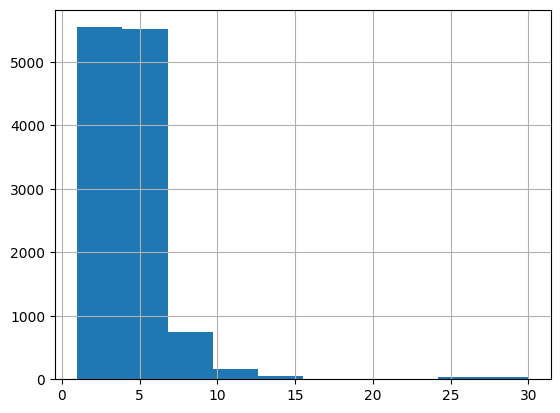

In [46]:
data['description'].apply(lambda x: len(x.split())).hist()

Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [7]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [8]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

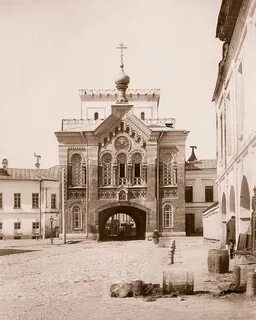

In [9]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [10]:
data['full_text'] = 'Название: '+ data['Name'] +'.' + 'Город: ' + data['City'] +'.' + 'Описание: ' + data['description']

In [11]:
text = data['full_text'].tolist()

In [12]:
text = list(set(text))

In [17]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.tools import tool

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = FAISS.from_texts(text, embedding=embeddings)
retriever = vectorstore.as_retriever(k=5)

In [33]:
index = vectorstore.index

In [34]:
num_vectors = index.ntotal

In [39]:
vectors = index.reconstruct_n(0, num_vectors)

In [18]:
@tool
def search_docs(query: str) -> str:
    """
    Найти релевантные фрагменты в моей локальной базе документов.
    """
    docs = vectorstore.similarity_search(query, k=5)
    return "\n\n---\n\n".join(d.page_content for d in docs)

In [19]:
system_prompt = """
Ты — дружелюбный и компетентный туристический гид по достопримечательностям России.

Твоя задача — помогать людям узнавать информацию о местах, зданиях, храмах, музеях,
памятниках и любых объектах из локальной базы данных.

Правила работы:

1. Сначала попытайся ответить на вопрос из своих общих знаний.
2. Если ты не уверен, не знаешь факт, или ответ может быть неполным —
   ОБЯЗАТЕЛЬНО вызови инструмент `search_docs` с формулировкой вопроса,
   чтобы найти информацию в локальной базе.
3. После получения контекста из `search_docs`, используй его, чтобы дать точный,
   корректный и полезный ответ.
4. Если в базе нет информации — скажи об этом честно и дай нейтральный ответ.
5. Не выдумывай факты, которых нет ни в твоих знаниях, ни в данных.
6. Всегда говори понятно, дружелюбно и в стиле настоящего гида.
"""


In [22]:
import os
os.environ["GROQ_API_KEY"] =

from langchain_groq import ChatGroq
model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2,
)

In [23]:
tools = [search_docs]

In [24]:
from langchain.agents import create_agent
agent = create_agent(
    model=model,
    tools=tools,
    system_prompt=system_prompt,
    name="Agentic RAG",
)

In [25]:
from langchain.messages import HumanMessage

response = agent.invoke({
    'messages': [
        HumanMessage(content=(
            "Куда сходить в Ярославле?"
        ))
    ]
})

In [26]:
response['messages'][-1].content

'В Ярославле есть много интересных мест, которые стоит посетить. Одним из них является Музей древнерусского искусства, который расположен в Митрополичьих палатах. Это историческое здание, которое датируется XVI веком и является одним из старейших в городе.\n\nЕще одним важным объектом является Спасо-Преображенский монастырь, который является одним из старейших в России. Монастырь был основан в XIII веке и является важным центром православной культуры.\n\nТакже стоит посетить Спасо-Преображенский собор, который является главной святыней монастыря. Собор был построен в XVI веке и является одним из лучших образцов русской архитектуры.\n\nДемидовский столп - это интересный памятник, который был построен в XVIII веке. Это высокое сооружение, которое было построено как символ благодарности Демидову за его вклад в развитие города.\n\nНаконец, стоит упомянуть Старообрядческий храм Иоанна Златоуста в Коровниках, который является важным центром старообрядчества в России. Храм был построен в XIX 

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [ ]:
# your code here

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

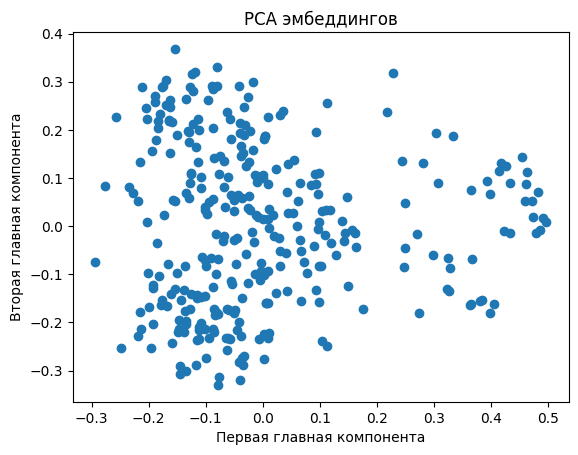

In [44]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)


plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('PCA эмбеддингов')
plt.show()

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

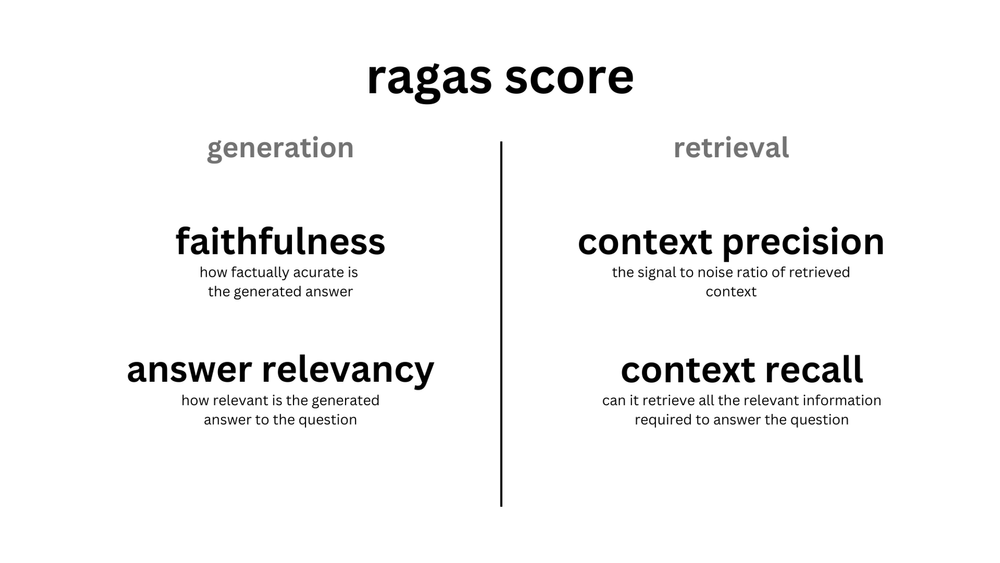

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [ ]:
def data_preprocess(...):
  # your code here
  return ...

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

def answer_relevancy(Ea,Eq,embeder):
  e_a = np.expand_dims(np.array(embeder.embed_query(Ea)),0)
  e_q = np.expand_dims(np.array(embeder.embed_query(Eq)),0)

  metrics = cosine_similarity(e_a,e_q)
  return metrics

In [74]:
answer_relevancy('sdadsa','asdasd',embeddings)[0][0]

np.float64(1.2742063907257688)

In [70]:
question =[
    "Куда поехать в России, если хочется увидеть северное сияние?",
    "Какие города Золотого кольца стоит посетить в первую очередь?",
    "Куда отправиться на Байкал: на Ольхон или в Листвянку?",
    "Где в России лучшие горнолыжные курорты для сноубордистов?",
    "Какой маршрут по Кавказу выбрать для треккинга летом?",
    "Куда поехать на неделю из Москвы, чтобы сменить обстановку?",
    "Какой круиз по Волге стоит взять для первого знакомства?",
    "Куда поехать в Карелии, если любишь активный отдых и рыбалку?",
    "Какой город Дальнего Востока самый интересный для туриста?",
    "Куда отправиться в Калининградской области кроме самого Калининграда?"
]

# Протестируйте ваш RAG (3 балла)

In [75]:
from tqdm import tqdm

In [77]:
sum_ = 0

for i in tqdm(question):
  response = agent.invoke({
    'messages': [
        HumanMessage(content=(
            i
        ))
    ]})
  answer = response['messages'][-1].content

  sum_ += answer_relevancy(answer,i,embeddings)[0][0]

final = sum_/len(question)

100%|██████████| 10/10 [01:37<00:00,  9.77s/it]


In [78]:
print(final)

0.5435849571080602


# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here